# NYT-GPT

In [ ]:
#installs (only need to the very frist time )
#pip install matplotlib
#pip install requests
#pip install pandas
#pip install openai
#pip install seaborn
#pip install spacy
#pip install wordcloud


In [1]:
# Imports
from textblob import TextBlob
import matplotlib.pyplot as plt
import requests, math, time
import csv, pathlib
import pandas as pd
import os
import openai
import json
import seaborn as sns
import json
import sys
import warnings
import spacy
from spacy.lang.en.examples import sentences 
import en_core_web_sm
from wordcloud import WordCloud

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
print("This program uses an ML natural language model (GPT-3) to summarize and analyze articles in the NYT\nto summarize and do sentiment analysis on a given subject, person, or location (or any other keyword) over time")
print("\nYou can input your query using natural language like this: \nSearch all articles about Michael Jackson from 1990 to his death")
print("\nSearch all articles about Enron since its IPO up to its collapse")

print("\nNote: If you want detailed and accurate answers, it is better to include the dates in the query.")

This program uses an ML natural language model (GPT-3) to summarize and analyze articles in the NYT
to summarize and do sentiment analysis on a given subject, person, or location (or any other keyword) over time

You can input your query using natural language like this: 
Search all articles about Michael Jackson from 1990 to his death

Search all articles about Enron since its IPO up to its collapse

Note: If you want detailed and accurate answers, it is better to include the dates in the query.


In [3]:
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

In [4]:
# Open the JSON file in read mode (OpenAI)
with open("..//api_key.json", "r") as f:
    # Load the JSON data from the file
    data = json.load(f)
    # Get the API key from the JSON data
    api_key = data["api_key"]

# Set the API key
openai.api_key = api_key

In [5]:
#Open the JSON files in read mode (NYT API Key)
with open("..//nyt_key.json", "r") as f:
    # Load the JSON data from the file
    data = json.load(f)
    # Get the API key from the JSON data
    api_key = data["api_key"]

# Set the API key
nyt_key = api_key

In [42]:
query = str(input("Enter the search query: "))

Enter the search query: find articles about mother theresa since 2010 to 2020


In [43]:
#turning the response from natural language to objects that are readable by the NYT API
response_keyword = openai.Completion.create(
  model="text-davinci-003",
  prompt="Find the main keyword (a name, a location, etc) from this query and nothing else: " + query,
  temperature=0.7,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

keyword = response_keyword.choices[0].text

def remove_leading_trailing_spaces(obj):
    # Use the strip() method to remove leading and trailing spaces
    return obj.strip()

keyword = remove_leading_trailing_spaces(keyword)

response_date = openai.Completion.create(
  model="text-davinci-003",
  prompt="In number format, and adding no extra text tell me the year, month, day (YYYYMMDD) relevant to this query (there should be two dates, beggining and end separated by a single comma). If no indication of time in query, output NA. Years start on 0101 and end 1231. If no end date, add today's date: " + query,
  temperature=0.5,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

dates = response_date.choices[0].text

# Split the input string into a list of dates
dates = dates.split(",")

# Assign the first date to begin_date
begin_date = dates[0]

# Assign the second date to end_date
end_date = dates[1]

# We need to remove all spaces and non-numeric characters
begin_date = ''.join([c for c in begin_date if c.isdigit()])
end_date = ''.join([c for c in end_date if c.isdigit()])

In [44]:
# Adding + signs for entries with multiple words
def format_keyword(keyword):
    # Split the keyword into a list of words
    words = keyword.split()
    
    # Join the words with a + separator
    formatted_keyword = "+".join(words)
    
    return formatted_keyword

keyword = format_keyword(keyword)

In [45]:
#checking out outputs
print(keyword)
print(begin_date)
print(end_date)

Mother+Teresa
20100101
20201231


In [46]:
# GETTING THE NUMBER OF HITS FIRST (WE DO NOT WANT TO EXCEED API CALL LIMIT TOO QUICKLY)
def get_num_hits(api_key, keyword, begin_date, end_date):
    # Set up the parameters for the API request
    base_url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}'

    params = {
        'api-key': api_key,
        'q': keyword,
        'page': 0,
        'begin_date': begin_date,
        'end_date': end_date
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    # Retrieve the number of hits
    num_hits = data['response']['meta']['hits']

    return num_hits


In [47]:
get_num_hits(nyt_key, keyword, begin_date, end_date)

910

In [48]:
# VERSION WITH ERROR HANDLING
# Version of NYT article search with the ability to run unlimited articles (NYT API limits to 100 hits per call)
def search_articles(api_key, keyword, begin_date, end_date):
    # Set up the parameters for the API request
    base_url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}'

    # Create an empty dataframe to store the results
    df = pd.DataFrame()

    # Set the number of articles to retrieve
    num_articles = 0

    # Perform the API request for each page
    page = 0
    while True:
        params = {
            'api-key': api_key,
            'q': keyword,
            'page': page,
            'begin_date': begin_date,
            'end_date': end_date
        }
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            raise Exception(f'Request failed with status code {response.status_code}')
        data = response.json()

        # Check if the response has the expected format
        if 'response' not in data or 'docs' not in data['response']:
            raise Exception(f'Unexpected response format: {data}')

        # Add the articles to the dataframe
        for article in data['response']['docs']:
            df = df.append(article, ignore_index=True)
            num_articles += 1

        # Check if there are more articles available
        if len(data['response']['docs']) == 0:
            break

        # Add a delay to avoid exceeding the API rate limit
        # The limit for the NYT API per docs is 6 seconds per request, 10 per minute
        #(https://developer.nytimes.com/faq#:~:text=Yes%2C%20there%20are%20two%20rate%20limits%20per%20API%3A,higher%20rate%20limit%2C%20please%20contact%20us%20at%20code%40nytimes.com.)
        time.sleep(6)
        page += 1
    
    return df


In [49]:
# Comprehensive search
# Can take anywhere from a few seconds to a few minutes to run depending on the number of hits (articles)
# check cell above to see how many hits there are
df = search_articles(nyt_key, keyword, begin_date, end_date)

In [32]:
df

,abstract,web_url,snippet,lead_paragraph,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name,print_page,print_section
0,The indictment charges Mr. Bankman-Fried with ...,https://www.nytimes.com/interactive/2022/12/13...,The indictment charges Mr. Bankman-Fried with ...,The indictment charges Mr. Bankman-Fried with ...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Here is the criminal indictment agai...,[],2022-12-13T16:02:52+0000,multimedia,U.S.,U.S.,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/973aca9f-5540-5fee-98e3-038c...,0,nyt://interactive/973aca9f-5540-5fee-98e3-038c...,NaN,NaN,NaN
1,The founder of the collapsed crypto exchange w...,https://www.nytimes.com/2022/12/13/business/se...,The founder of the collapsed crypto exchange w...,U.S. regulators filed civil securities fraud c...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'S.E.C. Charges Sam Bankman-Fried Wit...,"[{'name': 'subject', 'value': 'Securities and ...",2022-12-13T11:59:25+0000,article,Business,Business Day,"{'original': 'By Matthew Goldstein', 'person':...",News,nyt://article/be384380-8830-511d-8cc5-8b53c582...,457,nyt://article/be384380-8830-511d-8cc5-8b53c582...,NaN,NaN,NaN
2,The fallen founder of the cryptocurrency empir...,https://www.nytimes.com/2022/11/30/business/de...,The fallen founder of the cryptocurrency empir...,Why would Sam Bankman-Fried want to speak to t...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Ignoring Legal Advice, Sam Bankman-F...","[{'name': 'organizations', 'value': 'HK FTX Tr...",2022-12-01T00:33:30+0000,article,Business,Business Day,"{'original': 'By Ephrat Livni', 'person': [{'f...",News,nyt://article/ef88e994-2361-5491-92bb-7bde3a5e...,259,nyt://article/ef88e994-2361-5491-92bb-7bde3a5e...,DealBook,NaN,NaN
3,Federal prosecutors in Manhattan unsealed an e...,https://www.nytimes.com/2022/12/13/business/sb...,Federal prosecutors in Manhattan unsealed an e...,Federal prosecutors in Manhattan unsealed an e...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Read the Criminal Indictment Against...,[],2022-12-13T16:06:17+0000,article,Business,Business Day,"{'original': 'By Matthew Goldstein', 'person':...",News,nyt://article/618fd97a-8a70-5b5a-bb74-747c436a...,324,nyt://article/618fd97a-8a70-5b5a-bb74-747c436a...,NaN,NaN,NaN
4,Musk takes on tech’s fight against the Apple “...,https://www.nytimes.com/2022/12/02/podcasts/ha...,Musk takes on tech’s fight against the Apple “...,Elon Musk accuses Apple of trying to sabotage ...,The New York Times,[],{'main': 'Elon’s Two-Day War with Apple + How ...,"[{'name': 'subject', 'value': 'Science and Tec...",2022-12-02T10:00:25+0000,article,Podcasts,Podcasts,"{'original': 'By Kevin Roose, Casey Newton, Da...",News,nyt://article/a9d59e57-a14b-5f08-8414-2050ba0a...,230,nyt://article/a9d59e57-a14b-5f08-8414-2050ba0a...,NaN,NaN,NaN
5,The relationship between Alameda and FTX — and...,https://www.nytimes.com/2022/11/30/business/de...,The relationship between Alameda and FTX — and...,"Alameda Research, a small trading firm that Sa...",The New York Times,[],"{'main': 'FTX’s Sister Firm, Alameda Research,...","[{'name': 'organizations', 'value': 'Alameda R...",2022-11-30T22:08:30+0000,article,Business,Business Day,"{'original': 'By Matthew Goldstein, Alexandra ...",News,nyt://article/2bc39b4c-4f91-5afa-9059-69ae3b0d...,371,nyt://article/2bc39b4c-4f91-5afa-9059-69ae3b0d...,DealBook,NaN,NaN
6,The onetime crypto mogul also says he’s runnin...,https://www.nytimes.com/2022/11/30/business/de...,The onetime crypto mogul also says he’s runnin...,The FTX founder Sam Bankman-Fried said on Wedn...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Sam Bankman-Fried’s Phone Call to Hi...,"[{'name': 'subject', 'value': '

#NO NEED TO RUN THIS
#Version of NYT article search that returns the first 100 articles (faster but not comprehensive)
{def search_articles(api_key, keyword, begin_date, end_date):
    # Set up the parameters for the API request
    base_url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}'

    # Create an empty dataframe to store the results
    df = pd.DataFrame()

    # Set the number of pages to retrieve
    num_pages = 10

    # Perform the API request for each page
    for page in range(num_pages):
        params = {
            'api-key': nyt_key,
            'q': keyword,
            'page': page,
            'begin_date': begin_date,
            'end_date': end_date
        }
        response = requests.get(base_url, params=params)
        data = response.json()

        # Add the articles to the dataframe
        for article in data['response']['docs']:
            df = df.append(article, ignore_index=True)
    
    return df}

#NO NEED TO RUN THIS
#Testing limited search
df = search_articles(nyt_key, keyword, begin_date, end_date)


In [33]:
# function to reformat dates
def reformat_dates(data):
    data['pub_date'] = pd.to_datetime(data['pub_date'])
    data['pub_date'] = data['pub_date'].dt.date
    return data

In [34]:
# reformatting dates
reformat_dates(df)

,abstract,web_url,snippet,lead_paragraph,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name,print_page,print_section
0,The indictment charges Mr. Bankman-Fried with ...,https://www.nytimes.com/interactive/2022/12/13...,The indictment charges Mr. Bankman-Fried with ...,The indictment charges Mr. Bankman-Fried with ...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Here is the criminal indictment agai...,[],2022-12-13,multimedia,U.S.,U.S.,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/973aca9f-5540-5fee-98e3-038c...,0,nyt://interactive/973aca9f-5540-5fee-98e3-038c...,NaN,NaN,NaN
1,The founder of the collapsed crypto exchange w...,https://www.nytimes.com/2022/12/13/business/se...,The founder of the collapsed crypto exchange w...,U.S. regulators filed civil securities fraud c...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'S.E.C. Charges Sam Bankman-Fried Wit...,"[{'name': 'subject', 'value': 'Securities and ...",2022-12-13,article,Business,Business Day,"{'original': 'By Matthew Goldstein', 'person':...",News,nyt://article/be384380-8830-511d-8cc5-8b53c582...,457,nyt://article/be384380-8830-511d-8cc5-8b53c582...,NaN,NaN,NaN
2,The fallen founder of the cryptocurrency empir...,https://www.nytimes.com/2022/11/30/business/de...,The fallen founder of the cryptocurrency empir...,Why would Sam Bankman-Fried want to speak to t...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Ignoring Legal Advice, Sam Bankman-F...","[{'name': 'organizations', 'value': 'HK FTX Tr...",2022-12-01,article,Business,Business Day,"{'original': 'By Ephrat Livni', 'person': [{'f...",News,nyt://article/ef88e994-2361-5491-92bb-7bde3a5e...,259,nyt://article/ef88e994-2361-5491-92bb-7bde3a5e...,DealBook,NaN,NaN
3,Federal prosecutors in Manhattan unsealed an e...,https://www.nytimes.com/2022/12/13/business/sb...,Federal prosecutors in Manhattan unsealed an e...,Federal prosecutors in Manhattan unsealed an e...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Read the Criminal Indictment Against...,[],2022-12-13,article,Business,Business Day,"{'original': 'By Matthew Goldstein', 'person':...",News,nyt://article/618fd97a-8a70-5b5a-bb74-747c436a...,324,nyt://article/618fd97a-8a70-5b5a-bb74-747c436a...,NaN,NaN,NaN
4,Musk takes on tech’s fight against the Apple “...,https://www.nytimes.com/2022/12/02/podcasts/ha...,Musk takes on tech’s fight against the Apple “...,Elon Musk accuses Apple of trying to sabotage ...,The New York Times,[],{'main': 'Elon’s Two-Day War with Apple + How ...,"[{'name': 'subject', 'value': 'Science and Tec...",2022-12-02,article,Podcasts,Podcasts,"{'original': 'By Kevin Roose, Casey Newton, Da...",News,nyt://article/a9d59e57-a14b-5f08-8414-2050ba0a...,230,nyt://article/a9d59e57-a14b-5f08-8414-2050ba0a...,NaN,NaN,NaN
5,The relationship between Alameda and FTX — and...,https://www.nytimes.com/2022/11/30/business/de...,The relationship between Alameda and FTX — and...,"Alameda Research, a small trading firm that Sa...",The New York Times,[],"{'main': 'FTX’s Sister Firm, Alameda Research,...","[{'name': 'organizations', 'value': 'Alameda R...",2022-11-30,article,Business,Business Day,"{'original': 'By Matthew Goldstein, Alexandra ...",News,nyt://article/2bc39b4c-4f91-5afa-9059-69ae3b0d...,371,nyt://article/2bc39b4c-4f91-5afa-9059-69ae3b0d...,DealBook,NaN,NaN
6,The onetime crypto mogul also says he’s runnin...,https://www.nytimes.com/2022/11/30/business/de...,The onetime crypto mogul also says he’s runnin...,The FTX founder Sam Bankman-Fried said on Wedn...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Sam Bankman-Fried’s Phone Call to Hi...,"[{'name': 'subject', 'value': 'Regulation and ...",2022-12-01,article,Business,Business Day,"{'original': 'By Laure

In [52]:
#Sentiment Analysis and Seaborn code

# Combine the three text columns into one
df["text"] = df["abstract"].astype(str) + df["lead_paragraph"].astype(str) + df["byline"].astype(str)

# Create a new column for the sentiment scores with the TextBlob (NLP)
df["sentiment"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Format the pub_date column as a date
df["pub_date"] = pd.to_datetime(df["pub_date"])

# Plot the sentiment scores over time
#sns.lineplot(x="pub_date", y="sentiment", data=df)


In [50]:
df['headline']

0      {'main': 'Review: Mother Teresa Sings, in Drag...
1      {'main': 'Chappatte on Mother Teresa’s Canoniz...
2      {'main': 'Mother Teresa: The Life of a Saint',...
3      {'main': 'Rooting for Mother Teresa', 'kicker'...
4      {'main': 'Pope Francis Approves Sainthood for ...
                             ...                        
905    {'main': 'Corrections', 'kicker': None, 'conte...
906    {'main': 'Corrections', 'kicker': None, 'conte...
907    {'main': 'The Teacher Shortage', 'kicker': 'Le...
908    {'main': 'Abortion and the Democrats', 'kicker...
909    {'main': 'How College Changed My Life', 'kicke...
Name: headline, Length: 910, dtype: object

In [53]:
# plots the individual articles by data point number
# first sorts them in order of time, but does not display dates for visualization purposes (too many dates)
def bar_chart_points(data):
    data = data.sort_values(by='pub_date')
    fig, ax = plt.subplots()
    x = range(len(data['sentiment']))
    for i, val in enumerate(data['sentiment']):
        color = 'red' if val < 0 else 'green'
        ax.bar(i, val, color=color)
    plt.xlabel('Data Points')
    plt.ylabel('Sentiment')
    plt.show()

In [ ]:
df[]

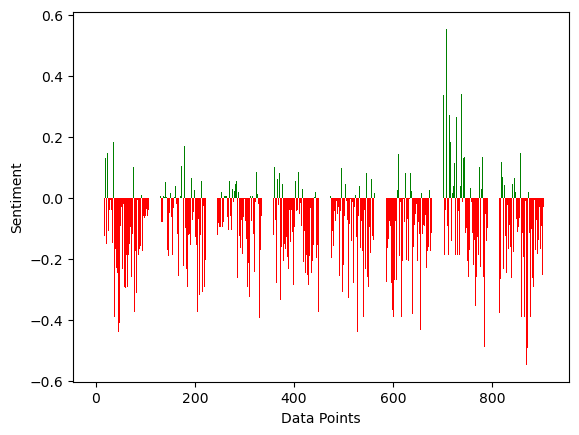

In [54]:
# plot_bar_chart_points function test
bar_chart_points(df)

In [55]:
# saving output as CSV
df.to_csv("mother_teresa.csv")

In [39]:
# average monthly sentiment function
# plots articles by average sentiment-month
def bar_chart_monthly(data):
    data = data.sort_values(by='pub_date')
    data['pub_date'] = pd.to_datetime(data['pub_date'])
    data['month'] = data['pub_date'].dt.strftime('%Y-%m')
    grouped = data.groupby('month').mean()
    fig, ax = plt.subplots()
    x = range(len(grouped.index))
    for i, val in enumerate(grouped['sentiment']):
        color = 'red' if val < 0 else 'green'
        ax.bar(x[i], val, color=color)
    plt.xticks(x, grouped.index, rotation=90)
    plt.xlabel('Month')
    plt.ylabel('Sentiment')
    plt.show()

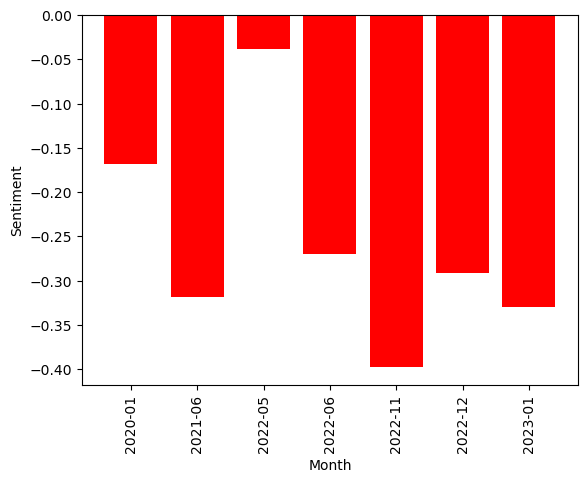

In [40]:
bar_chart_monthly(df)

#function to get the raw data for sentiment
def group_by_month(data):
    data['pub_date'] = pd.to_datetime(data['pub_date'])
    data['month'] = data['pub_date'].dt.strftime('%Y-%m')
    grouped = data.groupby('month').mean()
    return grouped

grouped_data = group_by_month(df)
print(grouped_data)

In [ ]:
# which articles are positive?

# Extract rows where sentiment is greater than or equal to 0
positive_sentiment_rows = df[df['sentiment'] >= 0]

# Print the resulting dataframe
positive_sentiment_rows


In [ ]:
# which articles are negative?

# Extract rows where sentiment is greater than or equal to 0
positive_sentiment_rows = df[df['sentiment'] <= 0]

# Print the resulting dataframe
positive_sentiment_rows


#TESTING SPACY -- BETTER FOR ARTICLES
nlp = spacy.load("en_core_web_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

#word type classification using spacy
import spacy
nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

#sentiment analysis using spacy 
#NOT WORKING -- ALL SENTIMENT IS SHOWN AS ZERO. NEED TO FIX
#Load the spaCy model
nlp = spacy.load("en_core_web_sm")

#Combine the three columns into one
df["text"] = df["abstract"].astype(str) + df["lead_paragraph"].astype(str) + df["byline"].astype(str)

#Create a new column for the sentiment scores
df["sentiment"] = df["text"].apply(lambda x: nlp(x).sentiment)

#Format the pub_date column as a date
df["pub_date"] = pd.to_datetime(df["pub_date"])

#Plot the sentiment scores over time
sns.lineplot(x="pub_date", y="sentiment", data=df)
